Accuracy: 0.9310344827586207
No scream detected


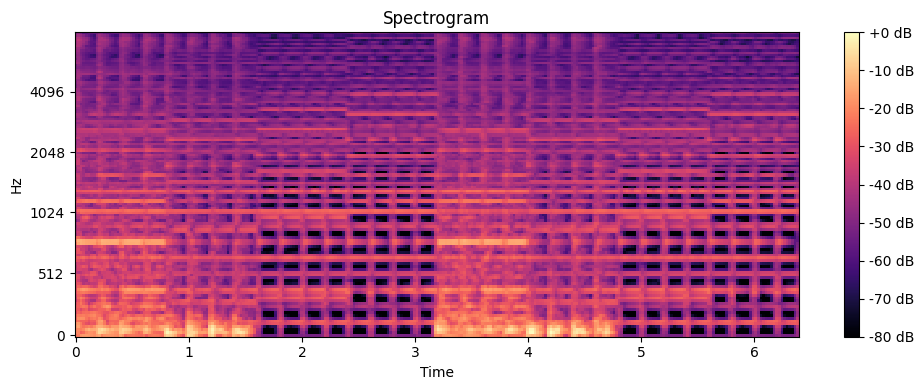

In [7]:
import numpy as np
import librosa
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import pickle

# Define function to extract features from audio signal
def extract_features(file_path, max_pad_len=500):
    X, sample_rate = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)
    spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(X)), ref=np.max)
    pad_width = max_pad_len - mfccs.shape[1]
    pad_width1 = max_pad_len - spectrogram.shape[1] 
    if pad_width < 0:
        mfccs = mfccs[:, :max_pad_len]
        spectrogram = spectrogram[:, :max_pad_len]
    else:
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        spectrogram = np.pad(spectrogram, pad_width=((0, 0), (0, pad_width)), mode='constant')
    combined_features = np.concatenate((mfccs.flatten(), spectrogram.flatten()))
    return combined_features


# Load positive and negative datasets
positive_dir = "./positive/positive/"
negative_dir = "./negative/negative/"

positive_files = [os.path.join(positive_dir, f) for f in os.listdir(positive_dir) if f.endswith('.wav')]
negative_files = [os.path.join(negative_dir, f) for f in os.listdir(negative_dir) if f.endswith('.wav')]

X = []
y = []
for file_path in positive_files:
    X.append(extract_features(file_path))
    y.append(1)
for file_path in negative_files:
    X.append(extract_features(file_path))
    y.append(0)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train SVM model
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

# save trained model using pickle
pickle.dump(clf, open("svm_model.pkl", "wb"))

# Evaluate model on testing set
accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)

# Use model to classify new audio signals
new_file_path = "./test.wav"
features = extract_features(new_file_path)

# load the model 
loaded_model = pickle.load(open("svm_model.pkl", "rb"))

prediction = loaded_model.predict(features.reshape(1, -1))

if prediction == 1:
    print("Scream detected")
else:
    print("No scream detected")

    
# Plot spectrogram of new audio signal
plt.figure(figsize=(10, 4))
y, sr = librosa.load(new_file_path)
spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
librosa.display.specshow(spectrogram_db, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.tight_layout()
plt.show()